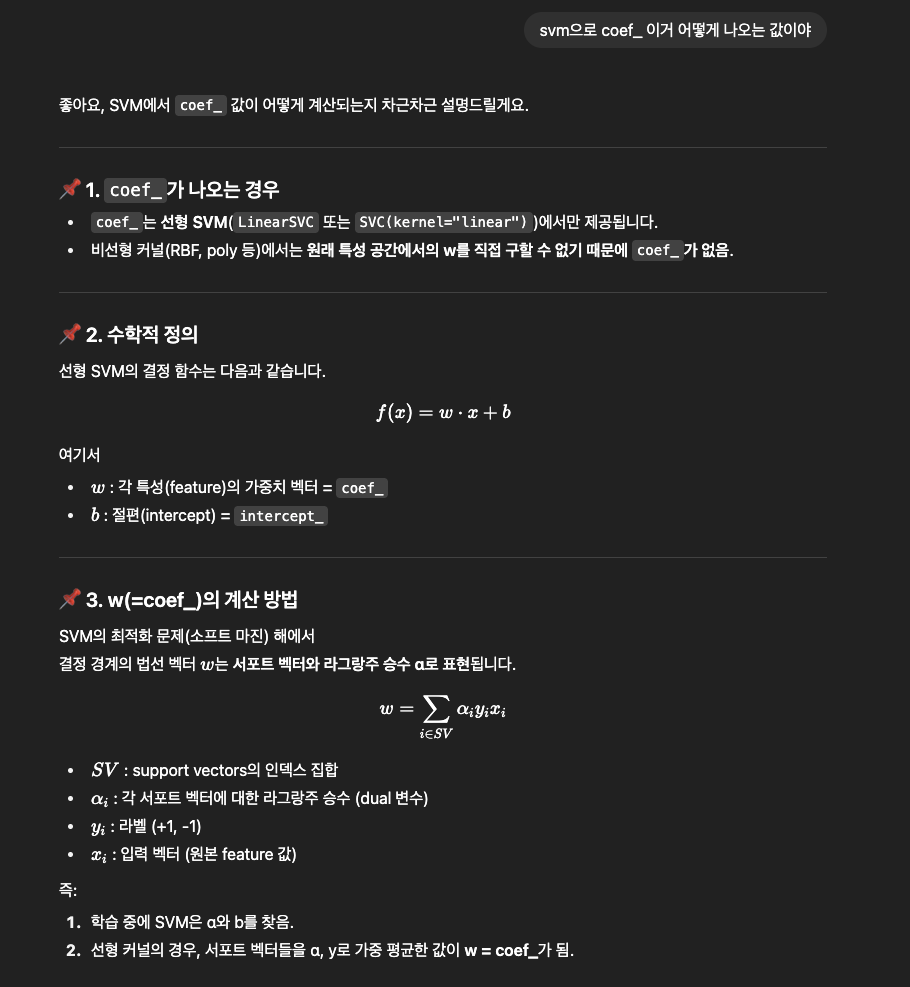

In [1]:
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# 간단한 데이터
X = np.array([[0, 0], [1, 1], [2, 2]])
y = np.array([-1, 1, 1])

clf = make_pipeline(StandardScaler(), SVC(kernel="linear", C=1.0))
clf.fit(X, y)

svm = clf.named_steps["svc"]

print("Support vectors:\n", svm.support_vectors_)
print("Dual Coefficients (alpha * y):\n", svm.dual_coef_)
print("coef_ (w):\n", svm.coef_)
print("intercept_ (b):", svm.intercept_)
# dual_coef_가 α*y 값이고, 이것을 support_vectors_에 곱해 모두 더하면 coef_가 나옵니다.


Support vectors:
 [[-1.22474487 -1.22474487]
 [ 0.          0.        ]]
Dual Coefficients (alpha * y):
 [[-0.66666667  0.66666667]]
coef_ (w):
 [[0.81649658 0.81649658]]
intercept_ (b): [1.]


In [4]:
from sklearn.datasets import make_classification
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd

X, y = make_classification(
    n_samples=1000, n_features=4, n_informative=3,
    n_redundant=0, random_state=0
)

pipe = make_pipeline(StandardScaler(), LinearSVC(C=1.0))
pipe.fit(X, y)

coef = pipe.named_steps["linearsvc"].coef_[0]
pd.DataFrame({
    "feature": range(X.shape[1]),
    "coef": coef,
    "abs_coef": abs(coef)
}).sort_values("abs_coef", ascending=False)
# feature 0: 값이 커질수록 양 클래스로 분류될 가능성 ↑

# feature 2: 값이 커질수록 음 클래스로 분류될 가능성 ↑

# 중요도 비교는 abs(coef)로

,feature,coef,abs_coef
3,3,0.588193,0.588193
1,1,-0.188539,0.188539
2,2,0.145643,0.145643
0,0,0.050689,0.050689


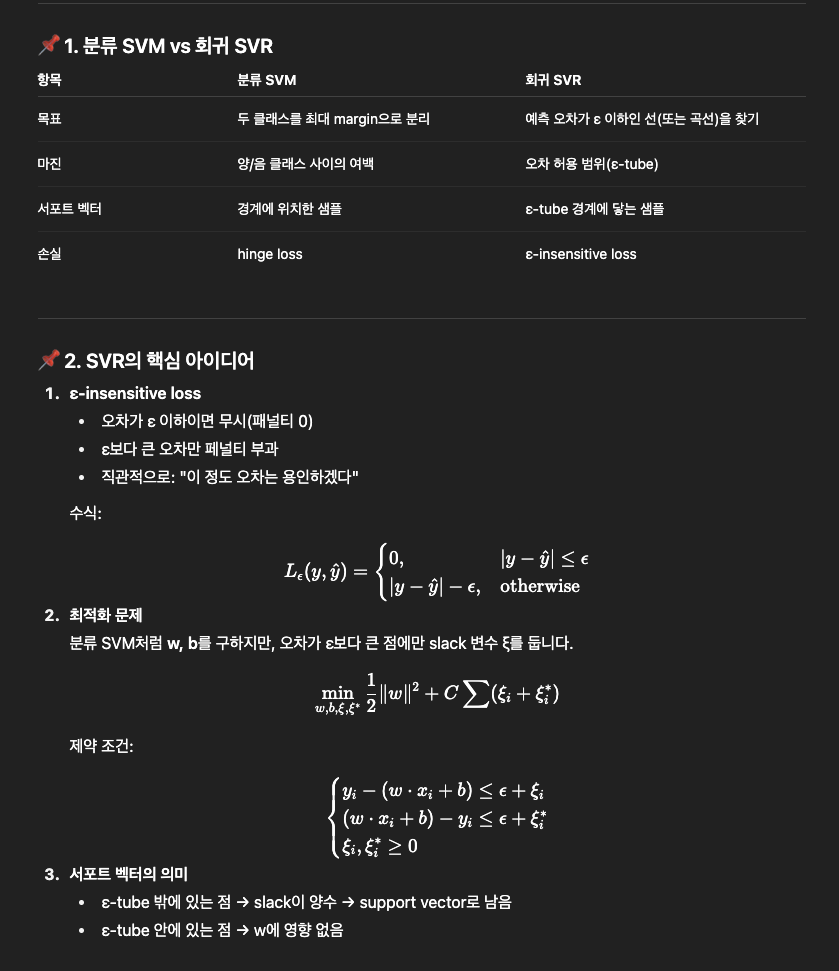

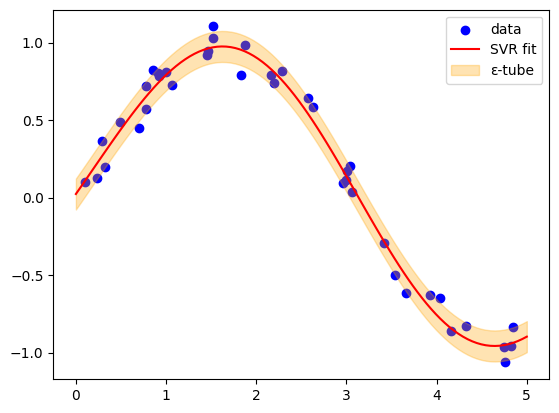

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR

# 데이터
rng = np.random.RandomState(42)
X = np.sort(5 * rng.rand(40, 1), axis=0)
y = np.sin(X).ravel() + rng.normal(0, 0.1, X.shape[0])
# svr_smallC = SVR(kernel='rbf', C=0.1, epsilon=0.1)
# svr_largeC = SVR(kernel='rbf', C=100, epsilon=0.1)
# SVR 학습
svr = SVR(kernel="rbf", C=100, epsilon=0.1, gamma=0.1)
svr.fit(X, y)

# 예측
X_test = np.linspace(0, 5, 100)[:, None]
y_pred = svr.predict(X_test)

# 시각화
plt.scatter(X, y, color='blue', label='data')
plt.plot(X_test, y_pred, color='red', label='SVR fit')
plt.fill_between(X_test.ravel(), y_pred - 0.1, y_pred + 0.1, color='orange', alpha=0.3, label='ε-tube')
plt.legend()
plt.show()

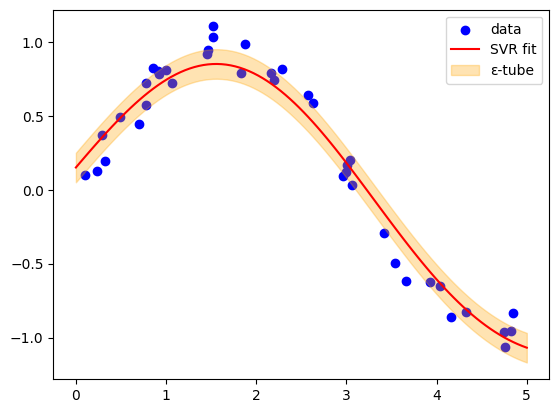

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR

# 데이터
rng = np.random.RandomState(42)
X = np.sort(5 * rng.rand(40, 1), axis=0)
y = np.sin(X).ravel() + rng.normal(0, 0.1, X.shape[0])

# SVR 학습
svr = SVR(kernel="rbf", C=1, epsilon=0.1, gamma=0.1)
svr.fit(X, y)

# 예측
X_test = np.linspace(0, 5, 100)[:, None]
y_pred = svr.predict(X_test)

# 시각화
plt.scatter(X, y, color='blue', label='data')
plt.plot(X_test, y_pred, color='red', label='SVR fit')
plt.fill_between(X_test.ravel(), y_pred - 0.1, y_pred + 0.1, color='orange', alpha=0.3, label='ε-tube')
plt.legend()
plt.show()

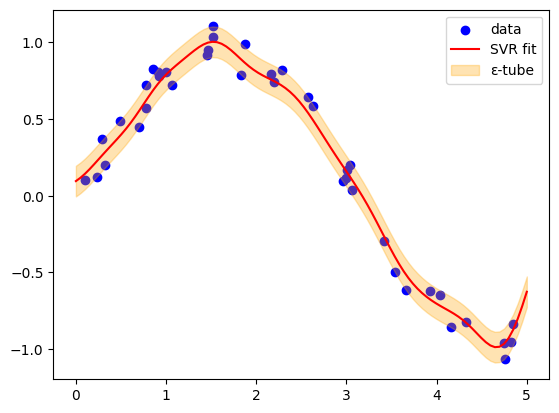

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR

# 데이터
rng = np.random.RandomState(42)
X = np.sort(5 * rng.rand(40, 1), axis=0)
y = np.sin(X).ravel() + rng.normal(0, 0.1, X.shape[0])

# SVR 학습
svr = SVR(kernel="rbf", C=1, epsilon=0.1, gamma=5)
svr.fit(X, y)

# 예측
X_test = np.linspace(0, 5, 100)[:, None]
y_pred = svr.predict(X_test)

# 시각화
plt.scatter(X, y, color='blue', label='data')
plt.plot(X_test, y_pred, color='red', label='SVR fit')
plt.fill_between(X_test.ravel(), y_pred - 0.1, y_pred + 0.1, color='orange', alpha=0.3, label='ε-tube')
plt.legend()
plt.show()

In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# 데이터
X, y = load_iris(return_X_y=True)
classes = np.unique(y)

# pipeline 정의
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LinearSVC(C=1.0, dual=False, multi_class="ovr", max_iter=5000))
])

# roc_auc_score 용 커스텀 스코어러
def auc_from_decision(estimator, X_val, y_val):
    scores = estimator.decision_function(X_val)

    # y를 one-hot으로 변환 (n_samples, n_classes)
    y_bin = label_binarize(y_val, classes=classes)

    return roc_auc_score(y_bin, scores, average="macro")  # 확률 아닌 점수 가능

# RFECV
rfecv = RFECV(
    estimator=pipe,
    step=1,
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    scoring=auc_from_decision,
    importance_getter=lambda est: est.named_steps["clf"].coef_,
    n_jobs=-1
)

rfecv.fit(X, y)

print("Selected mask:", rfecv.support_)
print("Feature ranking:", rfecv.ranking_)

# roc_auc_score(y_true, y_score, multi_class="ovr")에서 y_true가 one-hot이면

# y_score는 확률 or 점수 둘 다 허용됨

# 다만 행별로 클래스별 점수가 1로 sum 되지 않아도 OK

# 그래서 label_binarize()로 y만 one-hot 처리하면 해결됨


Selected mask: [False  True  True  True]
Feature ranking: [2 1 1 1]


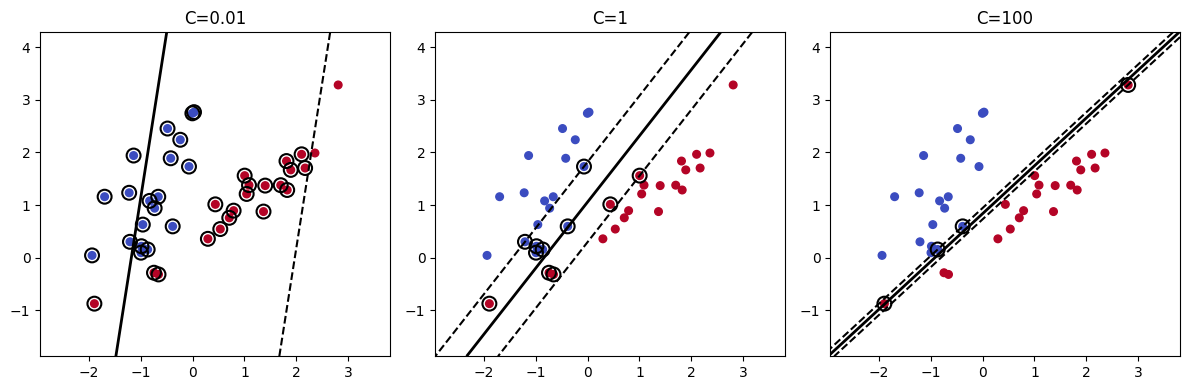

In [ ]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC
import numpy as np

# 데이터 생성
X, y = datasets.make_classification(
    n_features=2, n_redundant=0, n_informative=2,
    n_clusters_per_class=1, n_samples=40, random_state=42
)

# 다양한 C 값 실험
Cs = [0.01, 1, 100]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, C in zip(axes, Cs):
    clf = SVC(kernel="linear", C=C)
    clf.fit(X, y)
    
    # 서포트 벡터 시각화
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", s=30)
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
               s=100, facecolors="none", edgecolors="k", linewidths=1.5)
    
    # 결정경계 그리기
    xx, yy = np.meshgrid(np.linspace(X[:,0].min()-1, X[:,0].max()+1, 200),
                         np.linspace(X[:,1].min()-1, X[:,1].max()+1, 200))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors="k")
    ax.contour(xx, yy, Z, levels=[-1, 1], linestyles=["--","--"], colors="k")
    
    ax.set_title(f"C={C}")

plt.tight_layout()
plt.show()


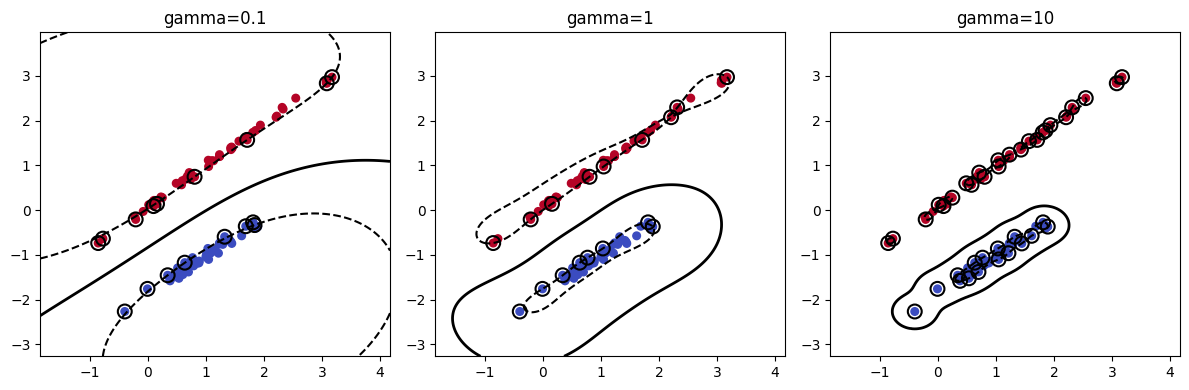

In [4]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC
import numpy as np

# 데이터 생성 (2D, 분류 문제)
X, y = datasets.make_classification(
    n_features=2, n_redundant=0, n_informative=2,
    n_clusters_per_class=1, n_samples=100, random_state=42
)

# 테스트할 파라미터
Cs = [1.0]
gammas = [0.1, 1, 10]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, gamma in zip(axes, gammas):
    clf = SVC(kernel="rbf", C=Cs[0], gamma=gamma)
    clf.fit(X, y)
    
    # 서포트 벡터 표시
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", s=30)
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
               s=100, facecolors="none", edgecolors="k", linewidths=1.5)
    
    # 결정경계 그리기
    xx, yy = np.meshgrid(np.linspace(X[:,0].min()-1, X[:,0].max()+1, 200),
                         np.linspace(X[:,1].min()-1, X[:,1].max()+1, 200))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors="k")
    ax.contour(xx, yy, Z, levels=[-1, 1], linestyles=["--","--"], colors="k")
    
    ax.set_title(f"gamma={gamma}")

plt.tight_layout()
plt.show()


In [47]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

c=pd.read_csv("https://raw.githubusercontent.com/ADPclass/ADP_book_ver01/main/data/classification.csv")


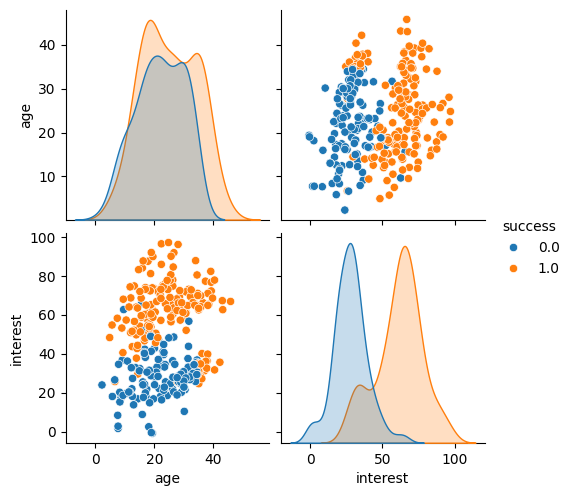

In [52]:
sns.pairplot(hue='success',data=c)
plt.show()

In [53]:
from sklearn.model_selection import train_test_split
x=c[['age','interest']]
y=c['success']
X_train,X_test,Y_train,Y_test=train_test_split(x,y,stratify=y, train_size=0.7, random_state=1)


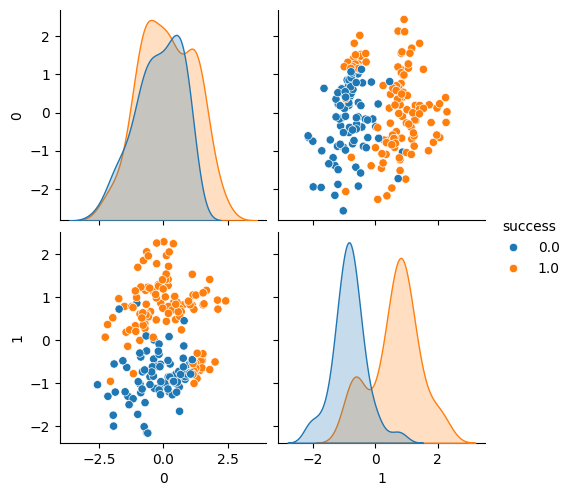

In [54]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
sns.pairplot(data=pd.concat([pd.DataFrame(X_train),Y_train.reset_index(drop=True)],axis=1),hue='success')
plt.show()


In [56]:
from sklearn.svm import SVC
clf=SVC(C=0.5,random_state=45)
clf.fit(X_train,Y_train)

from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score

test_x_scal=scaler.transform(X_test)
pred=clf.predict(test_x_scal)

test_cm=confusion_matrix(Y_test,pred)
test_acc=accuracy_score(Y_test,pred)
test_prc=precision_score(Y_test,pred)
test_rcll=recall_score(Y_test,pred)
test_f1=f1_score(Y_test,pred)

print(test_cm)
print('정확도 : ',test_acc*100,'%')
print('정밀도 : ',test_prc*100,'%')
print('재현율 : ',test_rcll*100,'%')
print('f1 : ',test_f1*100,'%')

[[37  2]
 [ 2 49]]
정확도 :  95.55555555555556 %
정밀도 :  96.07843137254902 %
재현율 :  96.07843137254902 %
f1 :  96.07843137254902 %


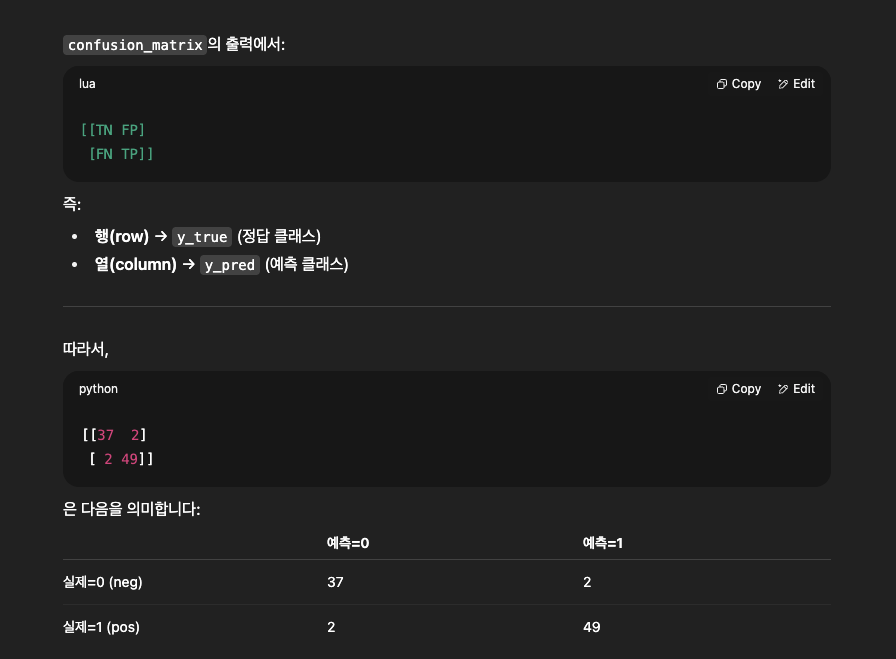

/var/folders/hv/lqp1gn9n1ll0lbh2pfzn9pww0000gn/T/ipykernel_5655/3781871097.py:19: UserWarning: The following kwargs were not used by contour: 'color'
  plt.contour(xx,yy,Z,color="k",levels=[-1,0,1],linestyles=['--','-','--'])
/opt/homebrew/Caskroom/miniforge/base/envs/general/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/var/folders/hv/lqp1gn9n1ll0lbh2pfzn9pww0000gn/T/ipykernel_5655/3781871097.py:19: UserWarning: The following kwargs were not used by contour: 'color'
  plt.contour(xx,yy,Z,color="k",levels=[-1,0,1],linestyles=['--','-','--'])


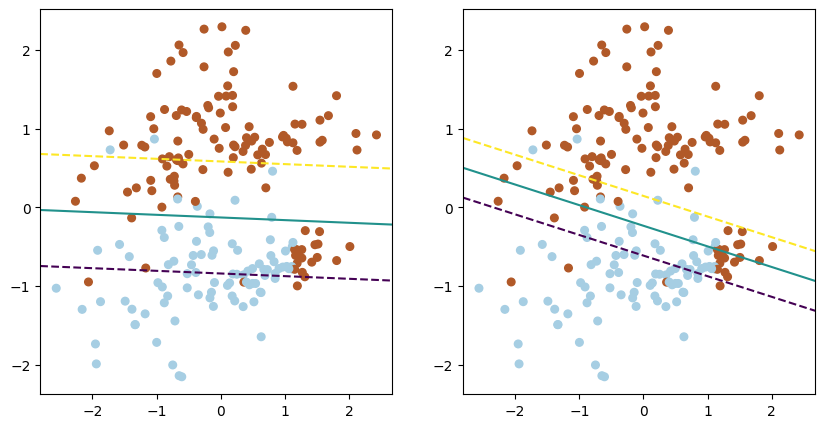

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC

plt.figure(figsize=(10,5))
for i,C in enumerate([0.1,100]):
    clf= LinearSVC(C=C,loss='hinge',random_state=42).fit(X_train,Y_train)
    decision_function=clf.decision_function(X_train)
    support_vector_index=np.where(np.abs(decision_function)<=1+1e-15)[0]
    support_vector=X_train[support_vector_index]
    plt.subplot(1,2,i+1)
    plt.scatter(X_train[:,0],X_train[:,1],c=Y_train,s=30,cmap=plt.cm.Paired)
    ax=plt.gca()
    xlim=ax.get_xlim()
    ylim=ax.get_ylim()
    xx,yy= np.meshgrid(np.linspace(xlim[0],xlim[1],50),np.linspace(ylim[0],ylim[1],50))
    Z=clf.decision_function(np.c_[xx.ravel(),yy.ravel()])
    Z=Z.reshape(xx.shape)
    plt.contour(xx,yy,Z,color="k",levels=[-1,0,1],linestyles=['--','-','--'])
plt.show()

In [71]:
xx.shape

(50, 50)